In [1]:
# This code tries to create a simulated replica of the published work in the paper 
# "Fast Pulse-Echo Ultrasound Imaging Employing Compressed Sensing" by "Martin F. Schiffner"
# and "Georg Schmitz"

import numpy as np
from scipy import special

# create grid points inside field of view
N_x = 64
N_z = 64

x_0 = 20*10**-3
z_0 = 20*10**-3
r_0 = np.array([[x_0],[z_0]])

delta_x = 14*10**-3
delta_z = 7*10**-3

e_x = np.array([[1],[0]])
e_z = np.array([[0],[1]])

i_x = np.linspace(0, N_x-1, N_x)
i_z = np.linspace(0, N_z-1, N_z)

r_i_x_z = r_0 + i_x*delta_x*e_x + i_z*delta_z*e_z
r_i_x_grid, r_i_z_grid = np.meshgrid(r_i_x_z[0,:], r_i_x_z[1,:])

r_i_x = r_i_x_grid.reshape(r_i_x_grid.shape[0]*r_i_x_grid.shape[1],1)
r_i_z = r_i_z_grid.reshape(r_i_z_grid.shape[0]*r_i_z_grid.shape[1],1)
r_i = np.concatenate((r_i_x, r_i_z),1).T

# create transducer elements
N_el = 32

l = np.linspace(0, N_el-1, N_el)
delta_s_x = 14*10**-3
r_m_l = (l-((N_el-1)/2))*delta_s_x*e_x

# determine propagation direction
e_v = np.array([np.cos(77.6*np.pi/180), np.sin(77.6*np.pi/180)])

# determine wavenumber
c_ref = 1500
T_s = 1/(20 * (10**6))
q_lb = 1
q_ub = 1648
t_lower = q_lb*T_s
t_upper = q_ub*T_s
l_lower = 215
l_upper = 220
N_f = 6
w_l = 2*np.pi*np.linspace(l_lower,l_upper,N_f)/(t_upper-t_lower)

k_0 = w_l/c_ref

# determine frequency dependent complex valued amplitude? (not specified in the paper)
A_in = k_0

# define green function
def green(r, k_0):
    return 1j*special.hankel2(0, k_0*np.linalg.norm(r))/4

# determine scattered pressure field coefficients matrix
G = np.zeros((N_el , N_x*N_z), dtype="complex")

print("discrete frequency indexes")
for k in np.arange(N_f):
    print(k)
    for i in np.arange(N_x*N_z):
        for ml in np.arange(N_el):
            G[ml,i] = k_0[k]**2 * A_in[k] * np.exp(-1j*k_0[k]*(e_v.dot(r_i[:,i])))*green((r_m_l[:,ml]-r_i[:,i]), k_0[k])        
    if k == 0:
        G_all = G
    else:
        G_all = np.concatenate((G_all, G), axis=0)

discrete frequency indexes
0
1
2
3
4
5


In [2]:
import pylops

# sparse solution with spectral projected-gradient for L1 norm
def sparse_solution(gamma_vector, G_all):
    G_normalized = G_all / np.linalg.norm(G_all, axis=0)
    
    G_op = pylops.MatrixMult(G_normalized, dtype=np.complex128)
    y = G_op*gamma_vector

    sparse_signal = pylops.optimization.sparsity.spgl1(G_op, y, verbosity=1)[0]
    
    return sparse_signal


SPGL1
No. rows              :      192     
No. columns           :     4096

Initial tau           : 0.00e+00     
Two-norm of b         : 3.00e-01

Optimality tol        : 1.00e-04     
Target objective      : 0.00e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :     1920


EXIT -- Found a root

Products with A     :      13        Total time   (secs) :     0.0
Products with A^H   :      11        Project time (secs) :     0.0
Newton iterations   :       1        Mat-vec time (secs) :     0.0
Line search its     :       2        Subspace iterations :       0


C:\Users\Cakiroglu\AppData\Local\Programs\Python\Python310\lib\site-packages\spgl1\spgl1.py:204: ComplexWarning: Casting complex values to real discards the imaginary part
  x *= s.astype(x.dtype)


Text(0.5, 1.0, 'Heat_Map')

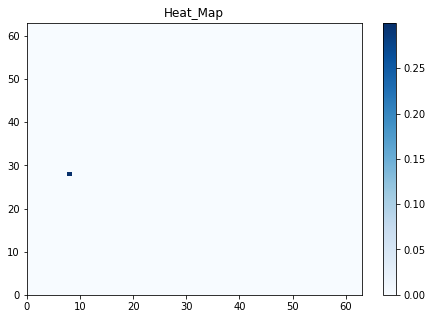

In [3]:
import matplotlib.pyplot as plt

# create compressibility fluctuations (one sparse element)
gamma_vector = np.zeros(G_all.shape[1])
gamma_vector[np.array([1800])] = 0.3

sparse_signal = sparse_solution(gamma_vector, G_all)
sparse_signal = sparse_signal.reshape(N_x,N_z)

sx = np.linspace(0, N_x-1, N_x)
sy = np.linspace(0, N_z-1, N_z)

# plot the figures
fig = plt.figure(figsize = (7.5,5))
fig.subplots_adjust(wspace=0.3)
plt.pcolormesh(sx, sy, np.real(sparse_signal), cmap=plt.cm.get_cmap('Blues'))
plt.colorbar()
plt.axis([0, N_x-1, 0, N_z-1])
plt.title('Heat_Map')


SPGL1
No. rows              :      192     
No. columns           :     4096

Initial tau           : 0.00e+00     
Two-norm of b         : 4.48e-01

Optimality tol        : 1.00e-04     
Target objective      : 0.00e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :     1920


EXIT -- Found a root

Products with A     :      23        Total time   (secs) :     0.1
Products with A^H   :      21        Project time (secs) :     0.0
Newton iterations   :       2        Mat-vec time (secs) :     0.0
Line search its     :       2        Subspace iterations :       0


Text(0.5, 1.0, 'Heat_Map')

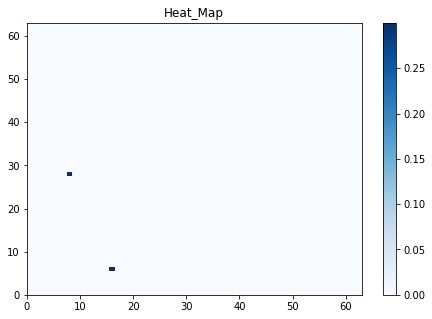

In [4]:
# create compressibility fluctuations (two sparse elements)

gamma_vector = np.zeros(G_all.shape[1])
gamma_vector[np.array([1800, 400])] = 0.3

sparse_signal = sparse_solution(gamma_vector, G_all)
sparse_signal = sparse_signal.reshape(N_x,N_z)

# plot the figures
fig = plt.figure(figsize = (7.5,5))
fig.subplots_adjust(wspace=0.3)
plt.pcolormesh(sx, sy, np.real(sparse_signal), cmap=plt.cm.get_cmap('Blues'))
plt.colorbar()
plt.axis([0, N_x-1, 0, N_z-1])
plt.title('Heat_Map')